In [11]:
#!/usr/bin/env python
# coding: utf-8


import os
import torch, pyro, numpy as np
torch.set_default_tensor_type(torch.cuda.FloatTensor)

import swyft
import click


DEVICE = 'cuda'

from utils import *
from network import CustomHead, CustomTail

In [17]:
import torch, numpy as np
torch.set_default_tensor_type(torch.cuda.FloatTensor)
from torch import tensor
import torch.nn as nn
import torchvision.transforms.functional as TF

In [22]:
import os
import torch, pyro, numpy as np
torch.set_default_tensor_type(torch.cuda.FloatTensor)
from torch import tensor
import torch.nn as nn
import torchvision.transforms.functional as TF


from clipppy import load_config, Clipppy
from clipppy.patches import torch_numpy
from ruamel.yaml import YAML

import swyft
import pyro.distributions as dist

import matplotlib.pyplot as plt
import numpy as np

In [23]:
m = 0
nsub = 3
nsim = 100

nmbins = 2

lr = 1e-3
factor = 1e-1
patience = 5
max_epochs = 4

In [24]:
# Set definitions (should go to click)
system_name = "ngc4414"

In [25]:
# Set utilities
sim_name, sim_path = get_sim_path(m, nsub, nsim, system_name)
store = swyft.DirectoryStore(path=sim_path)
print(f'Store has {len(store)} simulations.')

torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK
CONFIG = get_config(system_name, str(nsub), str(m))
torch.set_default_tensor_type(torch.FloatTensor)

prior, uv, lows, highs = get_prior(CONFIG)
L = CONFIG.kwargs["defs"]["nx"]
print(f'Image has L = {L}.')

Store _M_m0_nsub3_nsim100 exists!
Loading existing store.
Store has 88 simulations.
Image has L = 40.


In [30]:
def get_prior(config: Clipppy):
    """
    Set up subhalo parameter priors using a config
    """
    main = config.umodel.alphas["main"]
    prior_p_sub = main.sub.pos_sampler.base_dist
    m_sub_grid = main.sub.mass_sampler.y
    lows = np.array(
        [
            prior_p_sub.low[0].item(),
            prior_p_sub.low[1].item(),
            m_sub_grid.min().log10().item(),
        ]
    )
    highs = np.array(
        [
            prior_p_sub.high[0].item(),
            prior_p_sub.high[1].item(),
            m_sub_grid.max().log10().item(),
        ]
    )
    
    
    nsub = main.sub.nsub
    lows_u = np.tile(lows, nsub)
    highs_u = np.tile(highs, nsub)
    
    uv = lambda u: (highs_u - lows_u) * u + lows_u
    return swyft.Prior(uv, nsub*3), uv, lows, highs

prior, uv, lows, highs = get_prior(CONFIG)

In [108]:
from swyft.prior import get_diagonal_normal_prior

ModuleNotFoundError: No module named 'swyft.prior'

In [105]:
from swyft.types import Array
from swyft.utils import array_to_tensor, tensor_to_array
from torch.distributions import Normal

In [106]:
def get_diagonal_normal_prior(loc: Array, scale: Array) -> swyft.Prior:
    distribution = Normal(array_to_tensor(loc), array_to_tensor(scale))
    return swyft.Prior.from_torch_distribution(distribution)

In [107]:
get_diagonal_normal_prior(0.4, 0.3)

AttributeError: type object 'Prior' has no attribute 'from_torch_distribution'

In [93]:
from pyrofit.lensing.distributions import get_default_shmf

In [89]:
swyft.prior.get_diagonal_normal_prior()

AttributeError: module 'swyft' has no attribute 'prior'

['x_1', 'y_1', 'm_1', 'x_2', 'y_2', 'm_2', 'x_3', 'y_3', 'm_3']
Creating new store.
Store: Adding 10 new samples to simulator store.


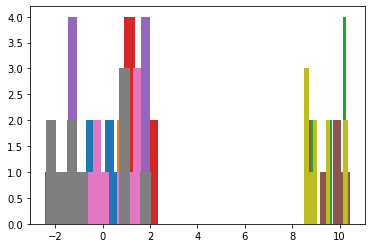

In [86]:
pnames = [f'{z}_{i+1}' for i in range(nsub) for z in ['x', 'y', 'm']]
print(pnames)
simulator = swyft.Simulator(model = lambda v: simul(v, CONFIG), 
                            pnames = pnames,
                            sim_shapes={"image": (L, L)})

store = swyft.MemoryStore(simulator = simulator)
store.add(10, prior)
store.simulate()

h = np.array([s[1] for s in store]).T

for i in h:
    plt.hist(i)
plt.show()

In [15]:
# Set up posterior
torch.set_default_tensor_type(torch.FloatTensor)
dataset = swyft.Dataset(nsim, prior, store)#, simhook = noise)
marginals = [i for i in range(L**2)]
post = swyft.Posteriors(dataset)

In [20]:
class DoubleConv(swyft.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False), # bias = False becaise BatchNorm2d is set
            nn.BatchNorm2d(out_channels), # BatchNorm2d were not known when paper came out
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(swyft.Module):
    def __init__(self, in_channels, out_channels, features = [64, 128, 256, 512]):
        super(UNET, self).__init__()
                
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # keep size the same
        

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        

    def forward(self, x, target):
                
        x = x.unsqueeze(1)
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1] # reverse list

        # the upsampling
        for idx in range(0, len(self.ups), 2): # step of 2 because we want up - double column - up - double column
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2] # //2 because we want still steps of one

            # if statement because we can put in shapes that are not divisble by two around 19:00 of video
            if x.shape != skip_connection.shape: 
                x = TF.resize(x, size=skip_connection.shape[2:]) # hopefully does not impact accuracy too much

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        x = self.final_conv(x)
        return x

    
class CustomHead(swyft.Module):
    def __init__(self, obs_shapes) -> None:
        super().__init__(obs_shapes=obs_shapes)
        self.n_features = torch.prod(tensor(obs_shapes['image']))
#         self.onl_norm = OnlineNormalizationLayer(torch.Size([self.n_features]))

    def forward(self, obs) -> torch.Tensor:
        x = obs["image"]
        n_batch = len(x)
        x = x.view(n_batch, self.n_features)
#         x = self.onl_norm(x)    
        return x

class Mapping:
#     def __init__(self):
    def __init__(self, nmbins, L, lows, highs):
#         super(Mapping, self).__init__()
        self.nmbins = nmbins
        self.L   = L
        self.lows = lows
        self.highs = highs

    def coord_vu(self, coords_v):
                        
        n = len(coords_v[0])/3
        assert n.is_integer()
        n = int(n)

        lows = np.full(coords_v.shape, np.tile(self.lows, n))
        highs = np.full(coords_v.shape, np.tile(self.highs, n))   
                
        u = lambda v: (v - lows) / (highs - lows)
        coords_u = u(coords_v)
        return coords_u

    def coord_to_map(self, XY_u):

        
        n_batch =  XY_u.shape[0]
        n_coords = XY_u.shape[1]*2/3
        assert n_coords.is_integer()

        z = torch.zeros((n_batch, self.nmbins + 1, self.L, self.L), device = DEVICE)
                
        if not (n_batch == 0 or n_coords == 0):
            
            x_sub_u, y_sub_u, log10_m_sub_u = XY_u.view(-1,3).T.to(DEVICE)

            x_i = torch.floor((x_sub_u*self.L).flatten()).type(torch.long) 
            y_i = torch.floor((y_sub_u*self.L).flatten()).type(torch.long) 
            m_i = torch.floor( log10_m_sub_u * self.nmbins ).type(torch.long) + 1
            
            i   = torch.floor(torch.arange(0, n_batch, 1/n_coords*2).to(DEVICE)).type(torch.long)
            xx = tuple(torch.stack((i, m_i, y_i, x_i)))
            z[xx] = 1

            xx = tuple(torch.stack((i, torch.zeros_like(m_i), y_i, x_i)))
            z[xx] = 1
            
        z[:,0] = 1 - z[:,0]

        return z

class CustomTail(swyft.Module):
    def __init__(self, n_features, marginals, **tail_args):
        super().__init__(n_features = n_features, marginals = marginals, **tail_args)
        
        
        self.n_features = n_features
        self.L = int(np.sqrt(n_features).item())
        self.nmbins = tail_args['nmbins']
        self.lows   = tail_args['lows']
        self.highs  = tail_args['highs']
        self.out_channels = self.nmbins + 1
  
        # self.Map  = Mapping()
        self.Map  = Mapping(self.nmbins, self.L, self.lows, self.highs)
        self.UNet = UNET(in_channels = 1, out_channels = self.out_channels)
        
       
    def forward(self, sims, target):
        
        sims = sims.view(-1, self.L, self.L)
        
        x = self.UNet(sims, target)
        z = self.Map.coord_to_map(target)
        
        x = x * z
        x = x.view(-1, self.n_features * self.out_channels)
        
        return x


# Train
post_name, post_path = get_post_path(sim_name, nmbins, lr, factor, patience)
print(f'Training {post_name}!')

torch.set_default_tensor_type(torch.FloatTensor)
post = swyft.Posteriors(dataset)
post.add(marginals, device = DEVICE, 
         tail_args = dict(nmbins = nmbins, lows = lows, highs = highs),
         head = CustomHead, tail = CustomTail)
post.train(marginals, max_epochs = max_epochs,
           optimizer_args = dict(lr=lr),
           scheduler_args = dict(factor = factor, patience = patience)
          )
# post.save(post_path)

Training UNet_M_m0_nsub3_nsim100_nmbins2_lr-3.0_fac-1.0_pat5.pt!
Training: lr=0.001, Epoch=4, VL=6658


In [ ]:
print('Done!')